In [1]:
!pip install langdetect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import regex as re
from PIL import Image
from langdetect import detect
import string
import re
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import names

warnings.filterwarnings('ignore')
sns.set_style('ticks')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.option_context('display.max_colwidth', 500);

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=3df7c20771d242f84a35cce426d75fcc705bfe7b5dffb3d63c8bcdbdb995a15b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
reviews = pd.read_csv("/content/drive/MyDrive/RegressionProject/combined_reviews.csv")

In [4]:
reviews['date'] = pd.to_datetime(reviews['date'])
dates_to_filter = ['2023-11-01', '2023-10-01', '2023-09-05', '2023-08-04', '2023-07-03', '2023-06-05']
reviews = reviews[reviews['date'].isin(dates_to_filter)]

In [5]:
reviews['listing_id'] = reviews['listing_id'].astype(int)
reviews['id'] = reviews['id'].astype(int)

In [9]:
reviews.head(10)

,listing_id,id,date,reviewer_id,reviewer_name,comments
1187,54508,927529798559134848,2023-07-03,24594880,Jennifer,"Kathleen was an excellent host, and her place ..."
2959,57166,927529459829559552,2023-07-03,300278629,Anna,This is second time we have stayed here and it...
3892,12192,973906533374265216,2023-09-05,533648001,Amos,Great location and convenient
7361,59709,927511952425235840,2023-07-03,394190934,Sindy,I absolutely loved staying at their place!! Th...
8156,107630,950800691359251200,2023-08-04,269010692,Philipp,Wir haben uns bei Maya sehr wohl gefühlt. Es w...
9195,60666,950796057919530752,2023-08-04,452625311,Monze,"Excelente alojamiento! Wayne siempre atento, y..."
10645,16974,973913793400998400,2023-09-05,139381554,Ulrich,Eine tolle Unterkunft. Sehr angenehme Kommunik...
11856,135465,950800468372342400,2023-08-04,94888816,Cynthia,A nice and comfortable space to enjoy the city...
14787,150804,950756571326171776,2023-08-04,15750419,Dominique,"Très bel appartement, nous étions 4 très à l’a..."
15986,71010,907316742270106752,2023-06-05,535828,Ajamu,I can’t say enough about the incredibly educat...


In [ ]:
len(reviews['listing_id'].unique())

6230

In [ ]:
dfs = [
    (reviews , 'reviews')
    ]

def basic_eda(df, name):
    print(f"""-----------------------------------------------\n
{name} dataframe \n
Rows: {df.shape[0]}             Columns: {df.shape[1]}
Duplicated rows: {(df.duplicated(keep=False) == True).sum()}
Columns:
{pd.concat([pd.DataFrame(data=df.dtypes, columns=['data_type']),
         pd.DataFrame(data=df.isnull().sum(), columns=['num_nulls'])], axis=1)}
    \n""")
print("DATAFRAME DESCRIPTION")

[basic_eda(df, name) for (df,name) in dfs];

DATAFRAME DESCRIPTION
-----------------------------------------------

reviews dataframe 

Rows: 14713             Columns: 6
Duplicated rows: 9639
Columns:
                    data_type  num_nulls
listing_id              int64          0
id                      int64          0
date           datetime64[ns]          0
reviewer_id             int64          0
reviewer_name          object          0
comments               object          9
    



In [ ]:
reviews.dropna(subset=['comments'], inplace=True)
reviews = reviews.reset_index()
del reviews['index']

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14704 entries, 0 to 14703
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     14704 non-null  int64         
 1   id             14704 non-null  int64         
 2   date           14704 non-null  datetime64[ns]
 3   reviewer_id    14704 non-null  int64         
 4   reviewer_name  14704 non-null  object        
 5   comments       14704 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 689.4+ KB


In [ ]:
reviews[reviews['comments'].str.contains('\.com|\.org')]

,listing_id,id,date,reviewer_id,reviewer_name,comments


In [ ]:
def remove_hyperlink(phrase):
    phrase = re.sub(r"((http|https):\/\/)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", phrase)
    return phrase


In [ ]:
reviews['comments'] = reviews['comments'].map(remove_hyperlink)

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14704 entries, 0 to 14703
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     14704 non-null  int64         
 1   id             14704 non-null  int64         
 2   date           14704 non-null  datetime64[ns]
 3   reviewer_id    14704 non-null  int64         
 4   reviewer_name  14704 non-null  object        
 5   comments       14704 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 689.4+ KB


In [ ]:
!pip install polyglot
!pip install langdetect
!pip install pyicu
!pip install pycld2 morfessor polyglot

from langdetect import detect, DetectorFactory
from polyglot.detect import Detector
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np

DetectorFactory.seed = 0

def detect_language(text):
    detections = []
    try:
        detections.append(detect(text))
    except:
        detections.append(np.nan)

    try:
        polyglot_detector = Detector(text, quiet=True)
        if polyglot_detector.reliable:
            detections.append(polyglot_detector.language.code)
        else:
            detections.append(np.nan)
    except:
        detections.append(np.nan)

    detections = [det for det in detections if det is not np.nan]
    if detections:
        return max(set(detections), key=detections.count)
    return np.nan

def process_batch(titles):
    return [detect_language(title) for title in titles]

batch_size = 5000
batches = [reviews['comments'][i:i+batch_size] for i in range(0, reviews.shape[0], batch_size)]

with ThreadPoolExecutor(max_workers=5) as executor:
    languages = list(executor.map(process_batch, batches))

languages = [lang for sublist in languages for lang in sublist]

reviews['language'] = languages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=52558 sha256=45d577cf27b01d132fa7ab95c30a6395d189053d2ce79948201b67f9ac84bcb1
  Stored in directory: /root/.cache/pip/wheels/aa/92/4a/b172589446ba537db3bdb9a1f2204f27fe71217981c14ac368
Successfully built polyglot
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyicu: filename=PyICU-2.12-cp310-cp310-linux_x86_64.whl size=1754543 sha256=34091be0ad1890ab19563bef98105a14e61249c6378a66e997d7c56faff6a28e
  Stored in directory: /root/.cache/pip/wheels/74/60/95/66d97ac2fdc8be8e526c4254047405fe77feaf064282d1ad07
Successfully built pyicu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 17.5 MB/s eta 

In [ ]:
reviews.language.value_counts().head(20)

en       12328
fr         646
es         596
de         296
it          97
ko          93
nl          89
pt          88
zh-cn       61
ro          41
so          41
pl          28
ca          27
af          23
tl          22
ru          19
ja          19
da          18
cs          18
sv          16
Name: language, dtype: int64

In [ ]:
reviews = reviews[reviews.language == 'en'].reset_index()
del reviews['index']

In [ ]:
len(reviews['listing_id'].unique())

5399

In [ ]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
reviews['comments'] = reviews['comments'].map(decontracted)

In [ ]:
reviews['text_length'] = [len(x) for x in reviews['comments'].str.split(' ')]

In [ ]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,text_length
0,54508,927529798559134848,2023-07-03,24594880,Jennifer,"Kathleen was an excellent host, and her place ...",en,29
1,57166,927529459829559552,2023-07-03,300278629,Anna,This is second time we have stayed here and it...,en,12
2,12192,973906533374265216,2023-09-05,533648001,Amos,Great location and convenient,en,4
3,59709,927511952425235840,2023-07-03,394190934,Sindy,I absolutely loved staying at their place!! Th...,en,21
4,135465,950800468372342400,2023-08-04,94888816,Cynthia,A nice and comfortable space to enjoy the city...,en,45


In [ ]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [ ]:
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [ ]:
reviews['sentiment_neg'] = reviews['comments'].map(negative_score)
reviews['sentiment_neu'] = reviews['comments'].map(neutral_score)
reviews['sentiment_pos'] = reviews['comments'].map(positive_score)
reviews['sentiment_compound'] = reviews['comments'].map(compound_score)

Text(0, 0.5, 'Number of reviews')

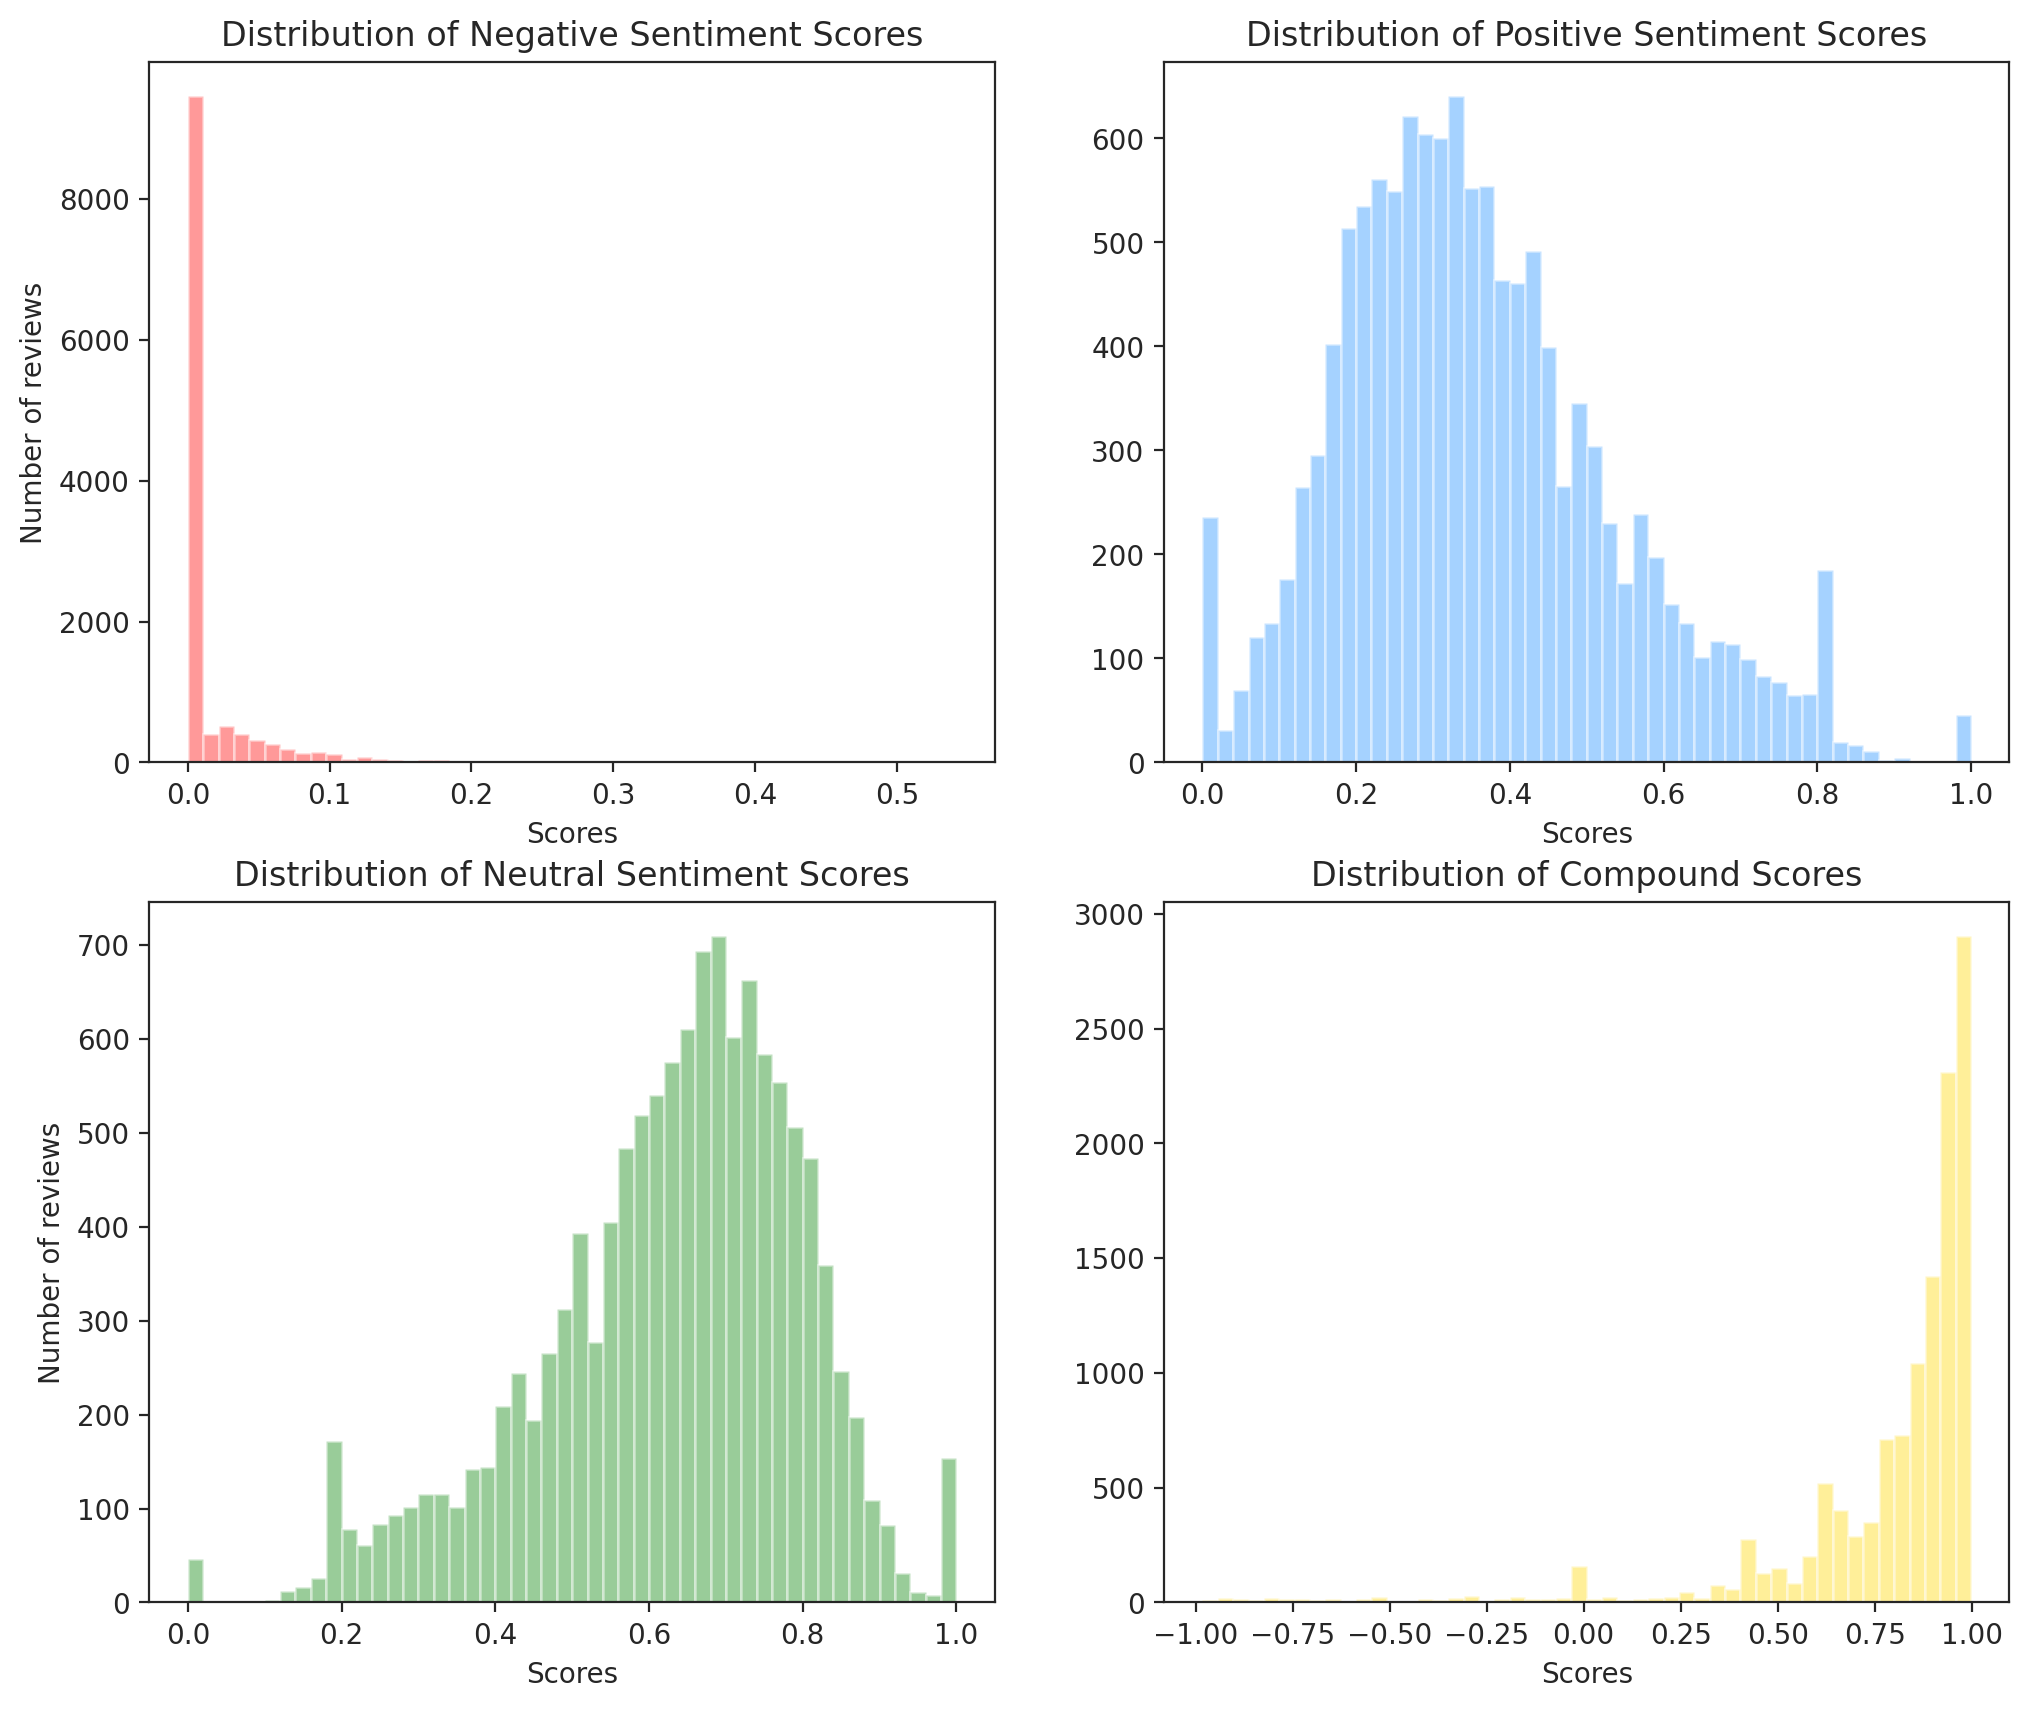

In [ ]:
# Plot histograms of sentiment scores
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))

sns.distplot(reviews['sentiment_neg'], hist = True, ax=ax[0][0], kde = False,color='r')
ax[0][0].set_title('Distribution of Negative Sentiment Scores', fontsize=12)
ax[0][0].set_xlabel('Scores', size=10)

sns.distplot(reviews['sentiment_pos'], hist = True, ax=ax[0][1], kde = False,color='dodgerblue')
ax[0][1].set_title('Distribution of Positive Sentiment Scores', fontsize=12)
ax[0][1].set_xlabel('Scores', size=10)

sns.distplot(reviews['sentiment_neu'], hist = True, ax=ax[1][0], kde = False,color='g')
ax[1][0].set_title('Distribution of Neutral Sentiment Scores', fontsize=12)
ax[1][0].set_xlabel('Scores', size=10)

sns.distplot(reviews['sentiment_compound'], hist = True, ax=ax[1][1], kde = False,color='gold')
ax[1][1].set_title('Distribution of Compound Scores', fontsize=12)
ax[1][1].set_xlabel('Scores', size=10)

ax[0][0].set_ylabel('Number of reviews')
ax[1][0].set_ylabel('Number of reviews')

In [ ]:
len(reviews[reviews['sentiment_compound']<0])

340

In [ ]:
reviews[reviews['sentiment_compound']<0].head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,text_length,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
13,295998,973903911020962176,2023-09-05,480519781,Ani,The balcony at Alan’s place was under construc...,en,153,0.091,0.894,0.016,-0.8720
49,783202,950771202571415424,2023-08-04,516052318,Paul,Lovely area and authentic feeling of being par...,en,20,0.136,0.703,0.160,-0.1157
102,3224913,907256043624661760,2023-06-05,50386919,Devon,Quick and easy stay in Brooklyn. No issues wit...,en,49,0.094,0.819,0.088,-0.0754
125,4532913,950813401736201984,2023-08-04,156039007,Daniel,Accurately described location. No issues with ...,en,8,0.239,0.761,0.000,-0.2960
158,5395679,907310052610787584,2023-06-05,63270062,Samantha,We stood in Zachs place for about one week. W...,en,135,0.069,0.892,0.039,-0.4959


In [ ]:
sentiment_scores = reviews[['listing_id','sentiment_compound']].groupby(by='listing_id').mean()
sentiment_scores = sentiment_scores.reset_index()

In [ ]:
sentiment_scores.head()


,listing_id,sentiment_compound
0,5178,-0.5267
1,5803,0.9949
2,12192,0.6249
3,27644,0.5719
4,29628,0.9223


In [ ]:
sentiment_scores.to_csv('/content/drive/MyDrive/RegressionProject/sentiment_scores.csv', index=False)

In [ ]:
for index, value in enumerate(reviews['sentiment_compound']):
    if value >= 0:
        reviews.loc[index,'sentiment'] = 'positive'
    else:
        reviews.loc[index,'sentiment'] = 'negative'

In [ ]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,text_length,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,sentiment
0,54508,927529798559134848,2023-07-03,24594880,Jennifer,"Kathleen was an excellent host, and her place ...",en,29,0.0,0.693,0.307,0.8768,positive
1,57166,927529459829559552,2023-07-03,300278629,Anna,This is second time we have stayed here and it...,en,12,0.0,0.715,0.285,0.6588,positive
2,12192,973906533374265216,2023-09-05,533648001,Amos,Great location and convenient,en,4,0.0,0.423,0.577,0.6249,positive
3,59709,927511952425235840,2023-07-03,394190934,Sindy,I absolutely loved staying at their place!! Th...,en,21,0.0,0.496,0.504,0.9456,positive
4,135465,950800468372342400,2023-08-04,94888816,Cynthia,A nice and comfortable space to enjoy the city...,en,45,0.0,0.657,0.343,0.9630,positive


In [ ]:
reviews['text_length'].groupby(reviews['sentiment']).describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,340.0,74.970588,60.430503,3.0,22.75,61.0,117.0,193.0
positive,11988.0,42.157324,39.182279,1.0,14.00,30.0,57.0,204.0


Text(0.5, 0, 'Sentiment')

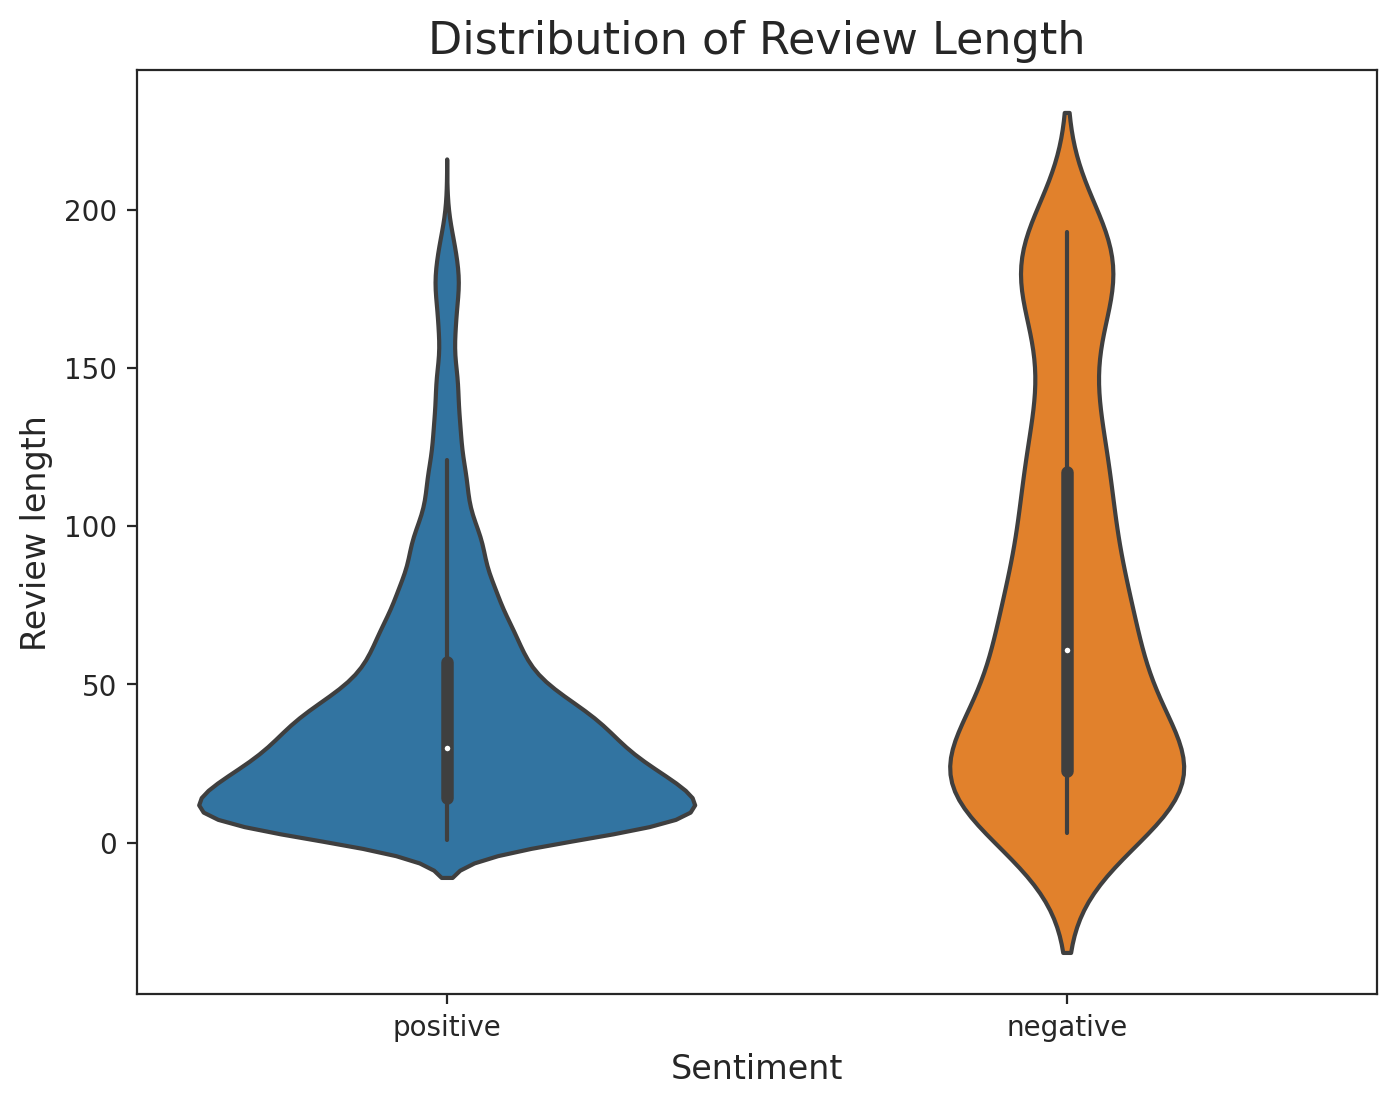

In [ ]:
# Plot distribution of review length
plt.figure(figsize = (8,6))
sns.violinplot(x='sentiment', y='text_length', data=reviews)

# Plot formatting
plt.title('Distribution of Review Length', size=16)
plt.ylabel("Review length", size=12)
plt.xlabel("Sentiment", size=12)

In [ ]:
upvote_mask = np.array(Image.open('/content/drive/MyDrive/upvote.png'))
downvote_mask = np.array(Image.open('/content/drive/MyDrive/downvote.png'))

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

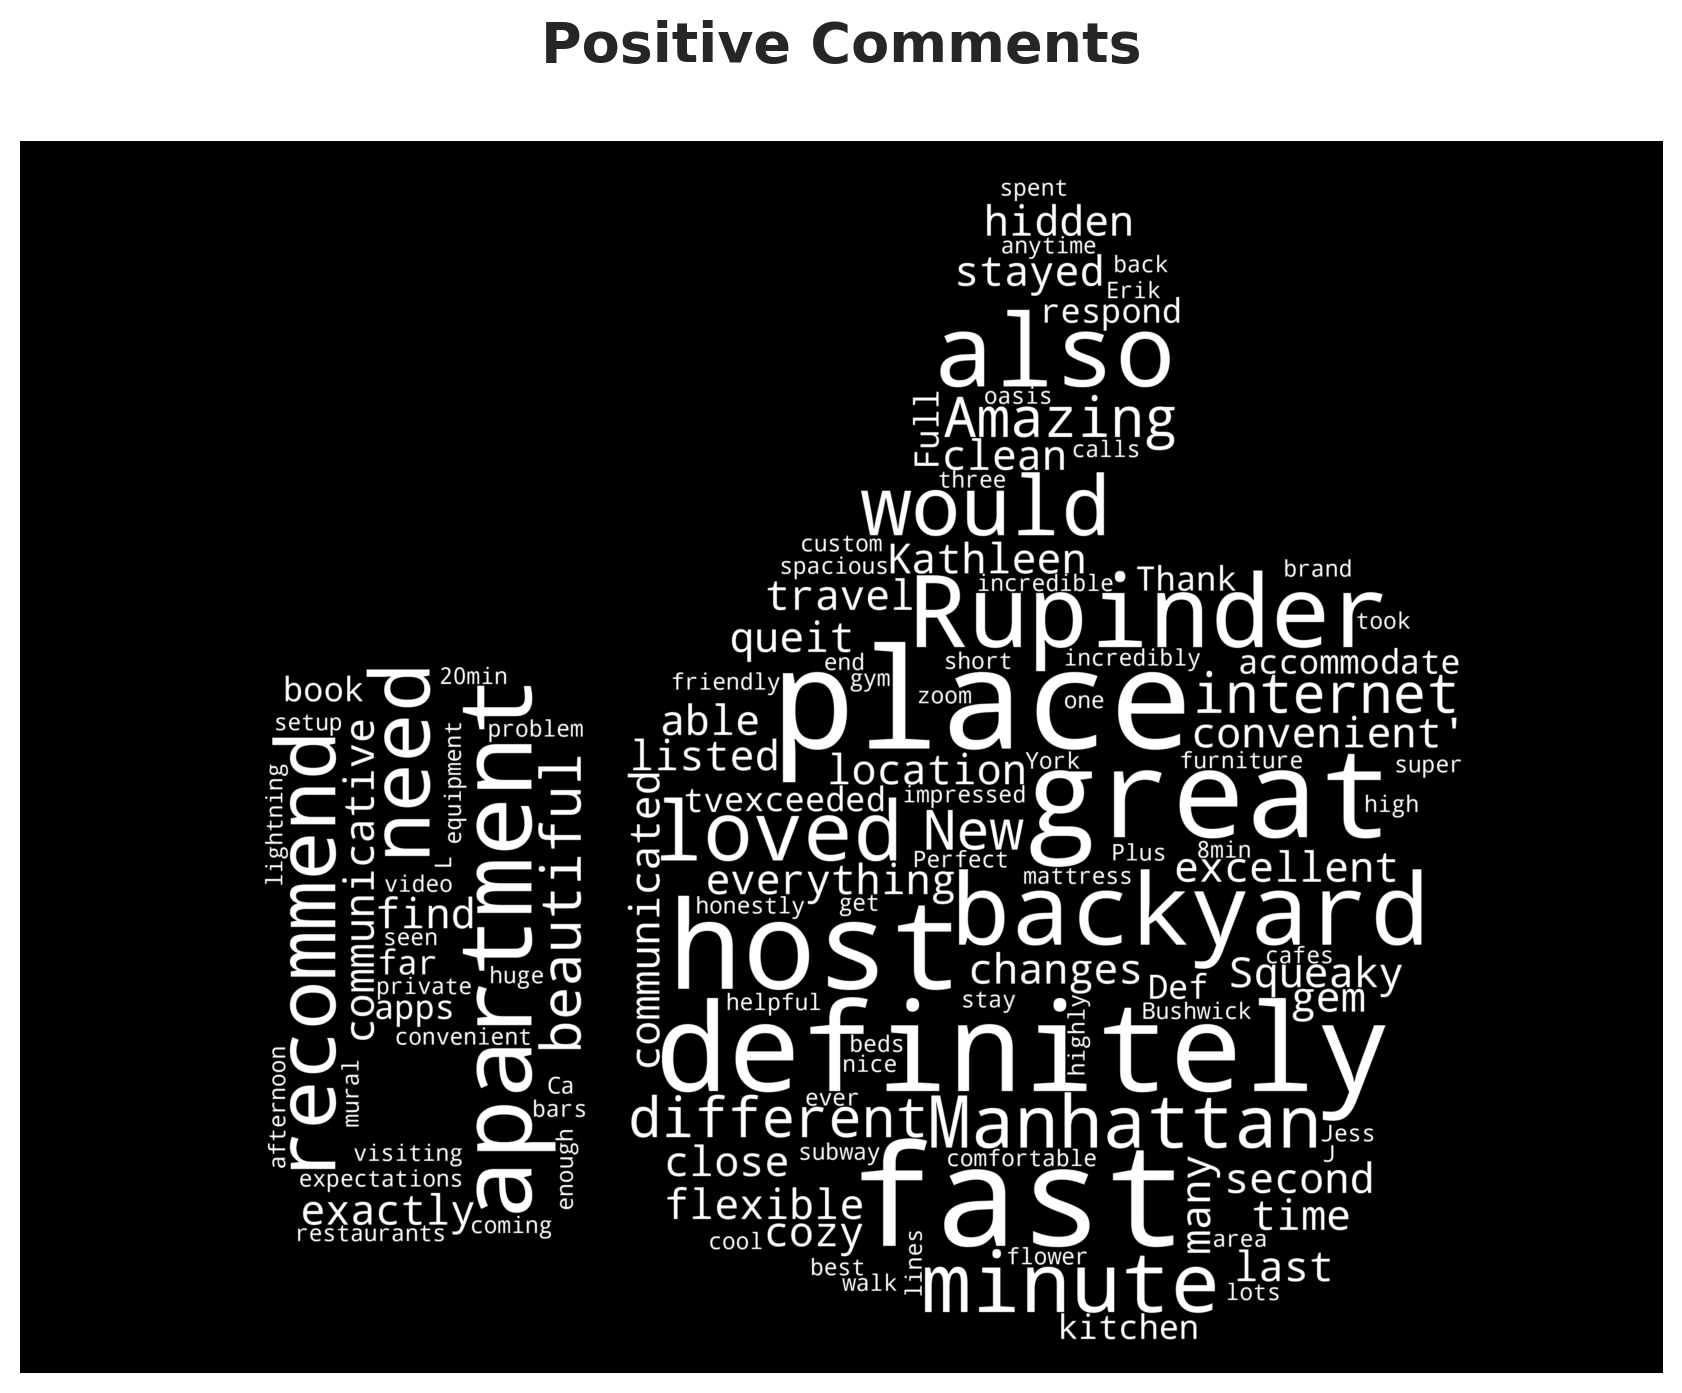

<Figure size 640x480 with 0 Axes>

In [ ]:
pos_wordcloud = WordCloud(max_font_size=350, max_words=200, background_color="black",
                      width= 3000, height = 2000, mask=upvote_mask,random_state=1,
                      color_func=lambda *args, **kwargs: "white",
                      stopwords = stopwords.words('english')).generate(str(reviews[reviews['sentiment']=='positive']['comments'].values))

plt.figure(figsize = (12,8))

plt.imshow(pos_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Positive Comments\n', fontsize=20, fontweight='bold')
plt.show()

plt.tight_layout()

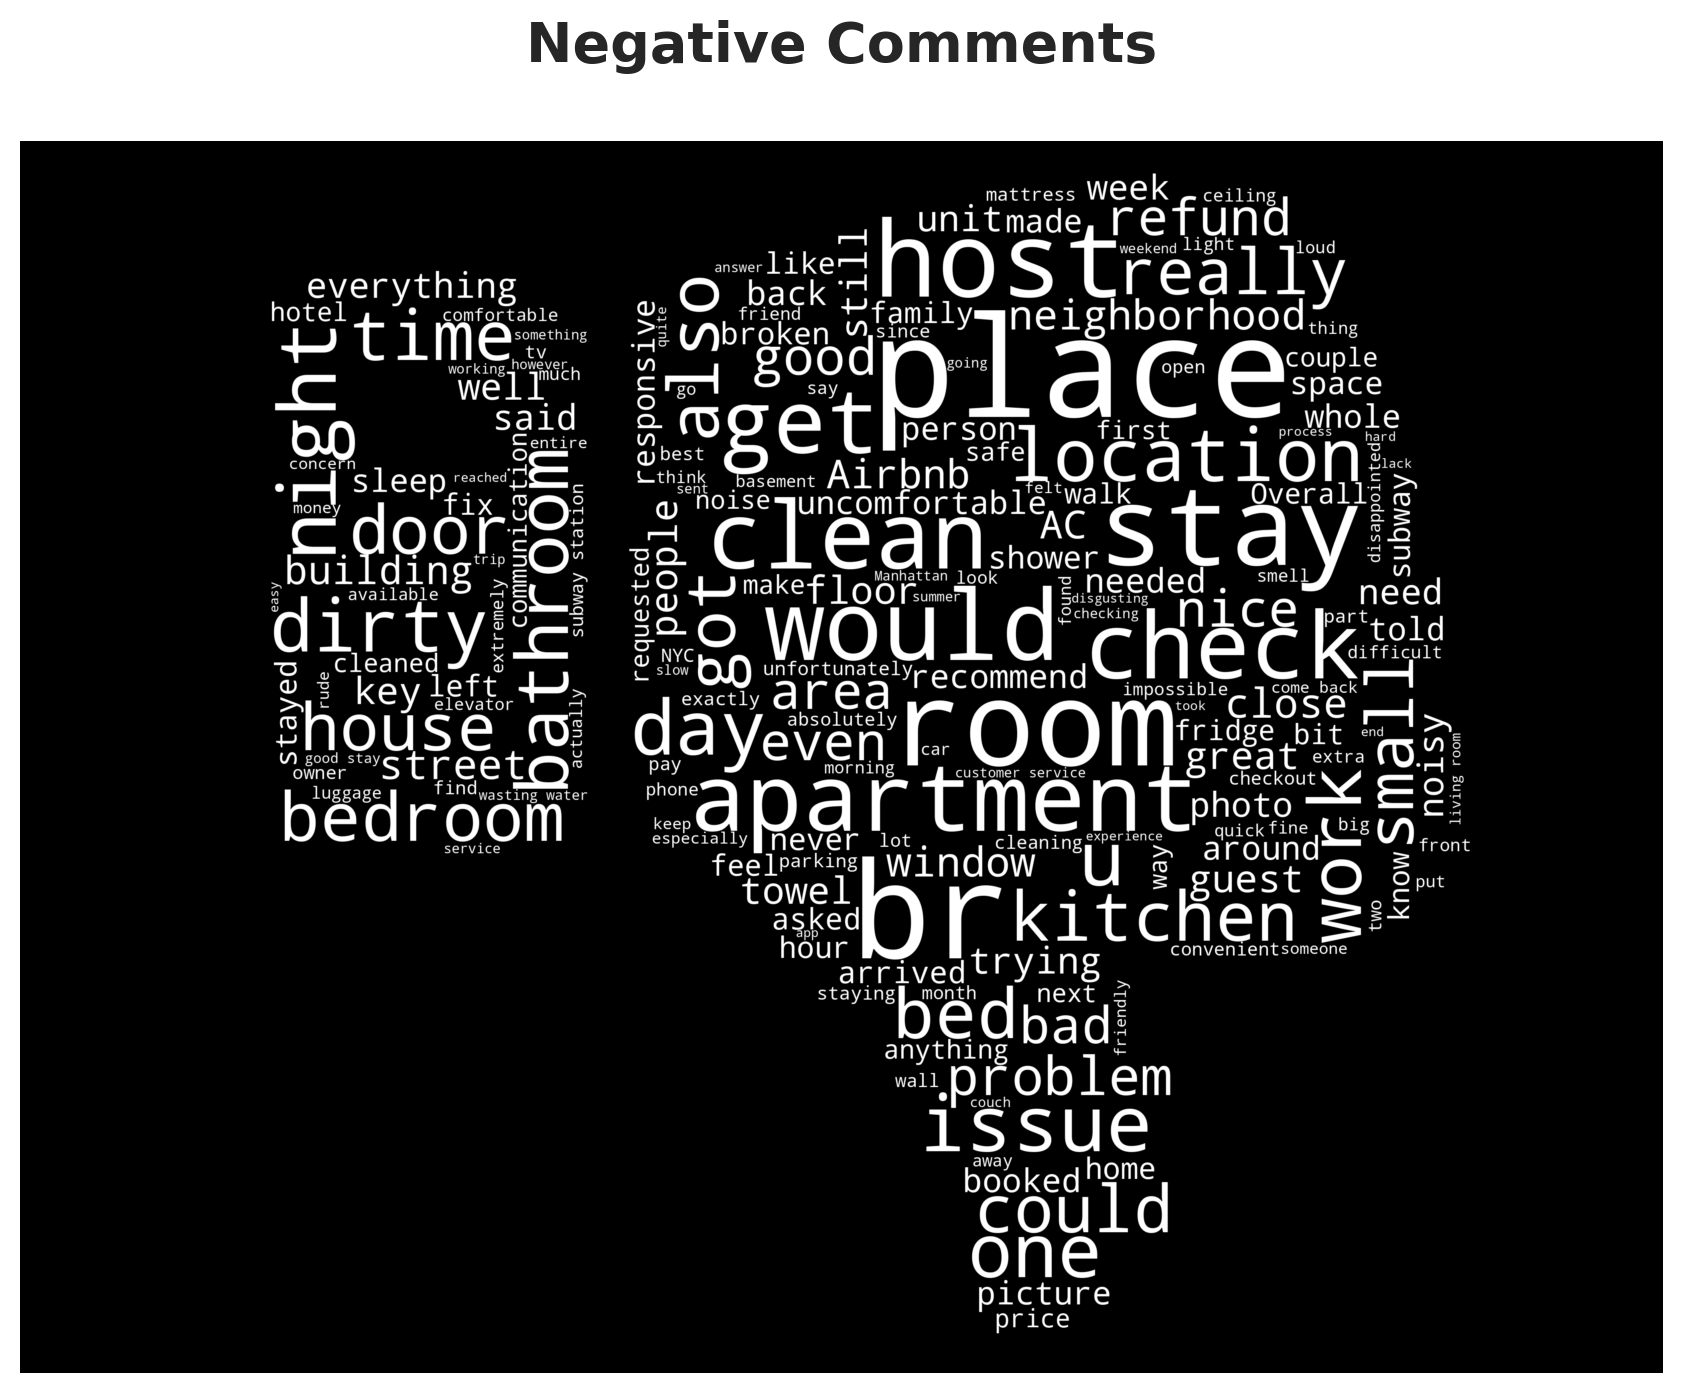

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot word cloud for negative reviews
neg_wordcloud = WordCloud(max_font_size=350, max_words=200, background_color="black",
                      width= 3000, height = 2000,mask=downvote_mask,random_state=1,
                      color_func=lambda *args, **kwargs: "white",
                      stopwords = stopwords.words('english')).generate(str(reviews[reviews['sentiment']=='negative']['comments'].values))

plt.figure(figsize = (12,8))

plt.imshow(neg_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Negative Comments\n', fontsize=20, fontweight='bold')
plt.show()

plt.tight_layout()

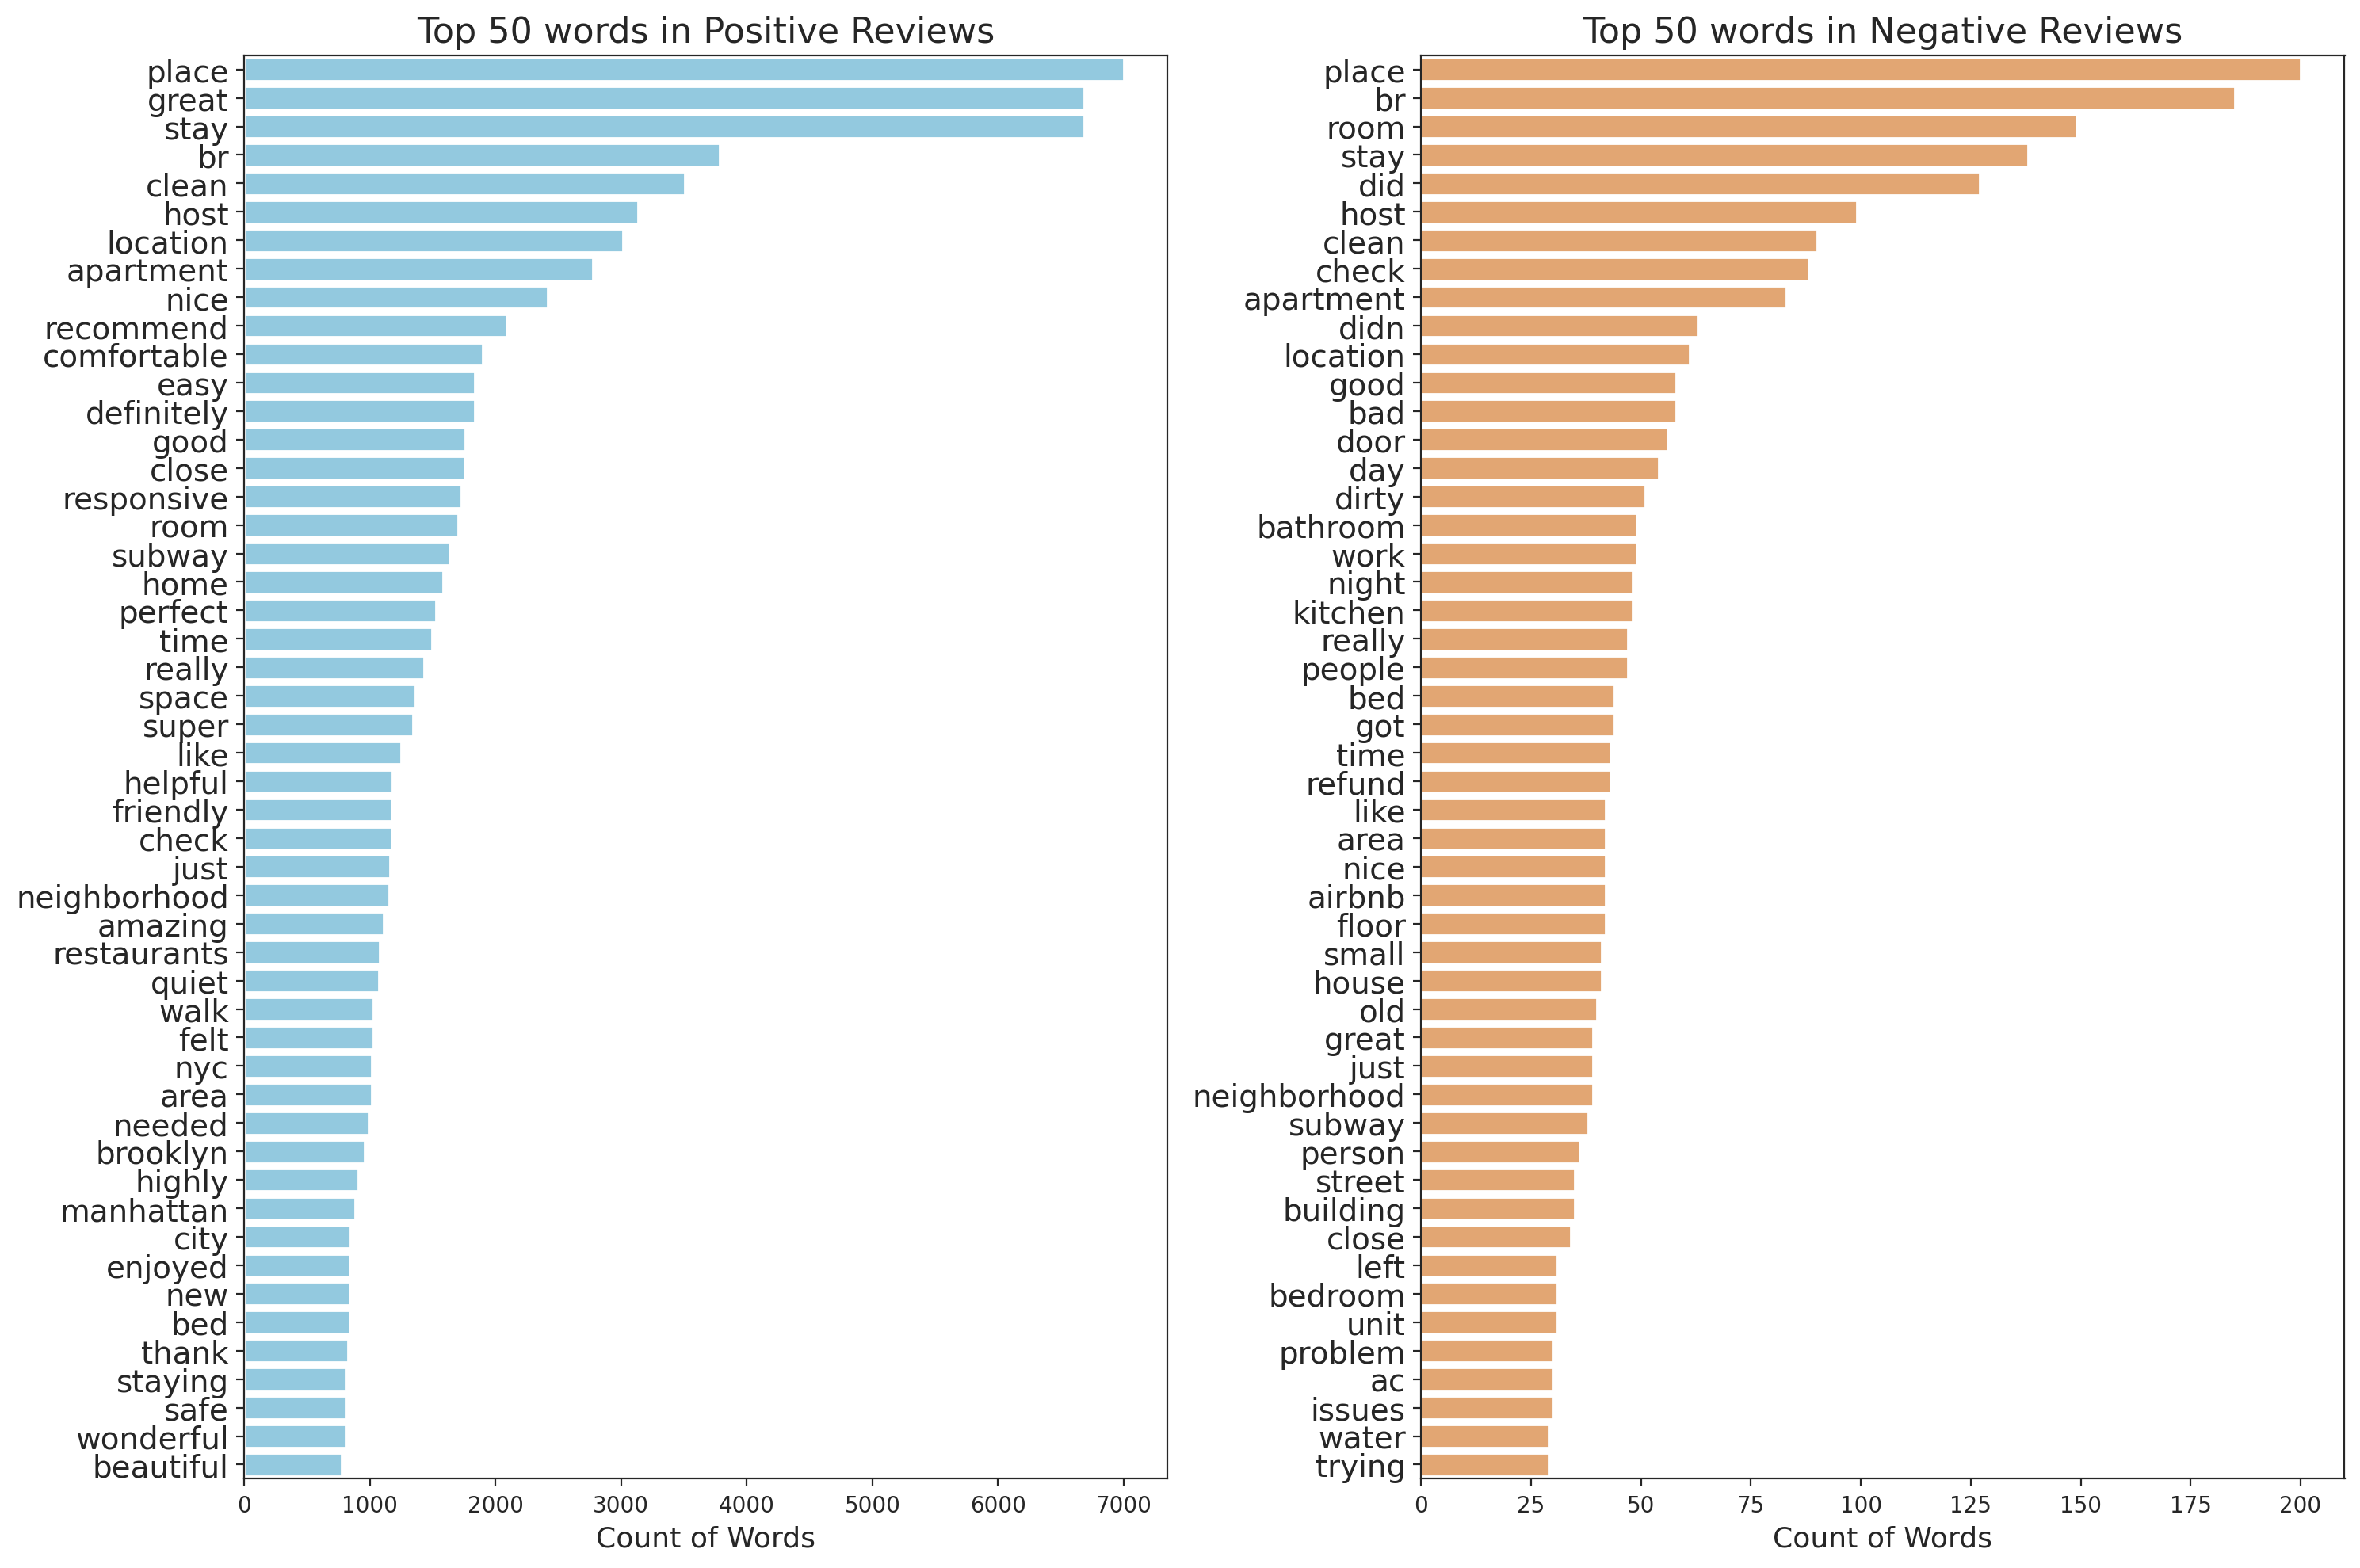

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize CountVectorizer
cvec = CountVectorizer(stop_words='english')  # 'english' removes common English stop words

# Fit and transform the vectorizer on positive comments
vec_positive = cvec.fit_transform(reviews[reviews['sentiment'] == 'positive']['comments'])
vec_positive = pd.DataFrame(vec_positive.toarray(), columns=cvec.get_feature_names_out())
positive_50 = vec_positive.sum().sort_values(ascending=False).head(50)

# Fit and transform the vectorizer on negative comments
vec_negative = cvec.fit_transform(reviews[reviews['sentiment'] == 'negative']['comments'])
vec_negative = pd.DataFrame(vec_negative.toarray(), columns=cvec.get_feature_names_out())
negative_50 = vec_negative.sum().sort_values(ascending=False).head(50)

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

sns.barplot(y=positive_50.index.values, x=positive_50, color='skyblue', ax=ax[0])
ax[0].set_title('Top 50 words in Positive Reviews', fontsize=16)
ax[0].set_xlabel('Count of Words', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=negative_50.index.values, x=negative_50, color='sandybrown', ax=ax[1])
ax[1].set_title('Top 50 words in Negative Reviews', fontsize=16)
ax[1].set_xlabel('Count of Words', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
!pip install spacy
!pip install pyLDAvis

from nltk.corpus import names
from nltk.corpus import stopwords
import spacy

from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.test.utils import datapath
from gensim.test.utils import common_texts, get_tmpfile

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
reviews['comments'] = reviews['comments'].map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x))

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('names')

from nltk.corpus import names


tokenizer = RegexpTokenizer(r'\w+', gaps=False)
stop_words = stopwords.words('english')
stop_words = set(stop_words)
punctuations = set(string.punctuation)
names = set(w.lower() for w in names.words())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


In [ ]:
!python -m spacy download en_core_web_sm

2023-12-07 07:57:14.376227: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 07:57:14.376285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 07:57:14.376312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 07:57:15.783832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Tokenize, Remove Stopwords and Lemmatization"""
    texts = [[word for word in tokenizer.tokenize(str(doc)) if (word.lower() not in set(stop_words | punctuations | names) and (len(word) > 1))] for doc in texts]

    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    for sentence in texts:
        doc = nlp(" ".join(sentence))
        texts_out.append([token.lemma_.lower() for token in doc if token.pos_ in allowed_postags])

    texts_out = [[word for word in tokenizer.tokenize(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

In [ ]:
reviews['tokens'] = process_words(reviews['comments'])


In [ ]:
bigram = Phrases(reviews['tokens'], min_count=10)
for i in range(len(reviews['tokens'])):
    for token in bigram[reviews['tokens'][i]]:
        if '_' in token:
            reviews['tokens'][i].append(token)

In [ ]:
dictionary = corpora.Dictionary(reviews[reviews['sentiment']=='positive']['tokens'])
print('Number of unique words in original documents:', len(dictionary))

dictionary.filter_extremes(no_below=20, no_above=0.1)
print('Number of unique words after removing rare and common words:', len(dictionary))

texts = reviews[reviews['sentiment']=='positive']['tokens']

corpus = [dictionary.doc2bow(text) for text in texts]

print(corpus[:1])

Number of unique words in original documents: 5212
Number of unique words after removing rare and common words: 1105
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [ ]:
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('change', 1),
  ('communicative', 1),
  ('excellent', 1),
  ('flexible', 1),
  ('last', 1),
  ('last_minute', 1),
  ('minute', 1)]]

In [ ]:
!pip install --upgrade gensim


In [ ]:
import os
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint


lda_model = LdaModel(corpus=corpus, num_topics=7, id2word=dictionary,
                     random_state=123, iterations=2000)

pprint(lda_model.show_topics(formatted=False, num_words=15))

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


[(0,
  [('bathroom', 0.021939132),
   ('bed', 0.015107834),
   ('space', 0.0149985915),
   ('kitchen', 0.014440001),
   ('work', 0.013059483),
   ('use', 0.012449324),
   ('check', 0.010771959),
   ('bedroom', 0.009901148),
   ('unit', 0.008068873),
   ('find', 0.0080382405),
   ('shower', 0.0073518837),
   ('smell', 0.007224399),
   ('distance', 0.0069530657),
   ('private', 0.006710131),
   ('water', 0.0066108545)]),
 (1,
  [('make', 0.021187497),
   ('check', 0.01701542),
   ('family', 0.016712144),
   ('experience', 0.0115872985),
   ('back', 0.011442687),
   ('friendly', 0.011334846),
   ('respond', 0.010903192),
   ('visit', 0.010606561),
   ('quickly', 0.010425162),
   ('next', 0.010211993),
   ('night', 0.009692597),
   ('go', 0.009466772),
   ('sure', 0.008721181),
   ('issue', 0.008363369),
   ('love', 0.008255055)]),
 (2,
  [('thank', 0.03523262),
   ('helpful', 0.031035528),
   ('back', 0.02193819),
   ('amazing', 0.020903591),
   ('wonderful', 0.018849807),
   ('come', 0.0

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=reviews['comments']):
    temp_series_list = []

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                temp_series = pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords])
                temp_series_list.append(temp_series)
            else:
                break

    sent_topics_df = pd.DataFrame(temp_series_list)
    sent_topics_df.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts).reset_index(drop=True)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=reviews[reviews['sentiment']=='positive']['comments'])

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percent_Contribution', 'Keywords', 'Text']

df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Percent_Contribution,Keywords,Text
0,0,2,0.6598,"thank, helpful, back, amazing, wonderful, come...","Kathleen was an excellent host, and her place ..."
1,1,5,0.7142,"amazing, check, city, restaurant, away, excell...",This is second time we have stayed here and it...
2,2,6,0.5703,"station, restaurant, neighborhood, enjoy, minu...",Great location and convenient
3,3,2,0.9046,"thank, helpful, back, amazing, wonderful, come...",I absolutely loved staying at their place!! Th...
4,4,6,0.9385,"station, restaurant, neighborhood, enjoy, minu...",A nice and comfortable space to enjoy the city...


In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Percent_Contribution'], ascending=[0]).head(2)],
                                            axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Percent_Contribution", "Keywords", "Text"]

sent_topics_sorteddf_mallet

,Topic_Num,Topic_Percent_Contribution,Keywords,Text
0,0,0.9874,"bathroom, bed, space, kitchen, work, use, chec...",Confirmation mentioned a $120 security deposit...
1,0,0.9874,"bathroom, bed, space, kitchen, work, use, chec...",Confirmation mentioned a $120 security deposit...
2,1,0.9722,"make, check, family, experience, back, friendl...",Really enjoyed our stay. Feels like home away...
3,1,0.9713,"make, check, family, experience, back, friendl...",Luz s place was a good place for me who was lo...
4,2,0.9722,"thank, helpful, back, amazing, wonderful, come...",Asha's apartment was perfect for my daughter's...
5,2,0.9722,"thank, helpful, back, amazing, wonderful, come...",Asha's apartment was perfect for my daughter's...
6,3,0.9773,"really, area, friendly, space, make, book, nei...",Great spot for the price! The tub is awesome. ...
7,3,0.9773,"really, area, friendly, space, make, book, nei...",Great spot for the price! The tub is awesome. ...
8,4,0.9843,"also, look, bed, exactly, make, small, picture...",It was such a pleasure to interact with Patric...
9,4,0.9843,"also, look, bed, exactly, make, small, picture...",It was such a pleasure to interact with Patric...


In [ ]:
neg_dictionary = corpora.Dictionary(reviews[reviews['sentiment']=='negative']['tokens'])

print('Number of unique words in original documents:', len(neg_dictionary))

neg_dictionary.filter_extremes(no_below=5, no_above=0.1)
print('Number of unique words after removing rare and common words:', len(neg_dictionary))

neg_texts = reviews[reviews['sentiment']=='negative']['tokens']

neg_corpus = [neg_dictionary.doc2bow(text) for text in neg_texts]

print(neg_corpus[:1])

Number of unique words in original documents: 1572
Number of unique words after removing rare and common words: 450
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


In [ ]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

lda_model_neg = LdaModel(corpus=neg_corpus, num_topics=6, id2word=neg_dictionary, random_state=123)

# Display topics
for idx, topic in lda_model_neg.show_topics(formatted=False, num_words=15):
    print('Topic: {} \nWords: {}'.format(idx, [w for w, _ in topic]))

# Calculate coherence
coherence_model_lda_neg = CoherenceModel(model=lda_model_neg, texts=neg_texts, dictionary=neg_dictionary, coherence='c_v')
coherence_lda_neg = coherence_model_lda_neg.get_coherence()
print('\nCoherence Score: ', coherence_lda_neg)


Topic: 0 
Words: ['great', 'towel', 'home', 'mention', 'quick', 'extra', 'br', 'window', 'side', 'street', 'thing', 'say', 'responsive', 'hear', 'block']
Topic: 1 
Words: ['floor', 'water', 'refund', 'find', 'well', 'really', 'actually', 'break', 'photo', 'service', 'next', 'say', 'neighborhood', 'bedroom', 'feel']
Topic: 2 
Words: ['smell', 'look', 'refund', 'photo', 'unit', 'nice', 'come', 'feel', 'ask', 'air', 'small', 'parking', 'also', 'right', 'fridge']
Topic: 3 
Words: ['also', 'old', 'really', 'week', 'guest', 'take', 'refund', 'small', 'give', 'message', 'overall', 'uncomfortable', 'neighborhood', 'feel', 'floor']
Topic: 4 
Words: ['much', 'picture', 'noisy', 'recommend', 'leave', 'arrive', 'comment', 'enjoy', 'subway', 'station', 'train', 'provide', 'come', 'person', 'rude']
Topic: 5 
Words: ['bedroom', 'street', 'building', 'also', 'really', 'floor', 'loud', 'service', 'neighborhood', 'small', 'nice', 'available', 'key', 'first', 'let']

Coherence Score:  0.28303587321103024

In [ ]:
df_neg_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_neg, corpus=neg_corpus, texts=reviews[reviews['sentiment']=='negative']['comments'])

df_dominant_topic = df_neg_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percent_Contribution', 'Keywords', 'Text']

df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Percent_Contribution,Keywords,Text
0,0,5,0.8185,"bedroom, street, building, also, really, floor...",The balcony at Alan s place was under construc...
1,1,4,0.8601,"much, picture, noisy, recommend, leave, arrive...",Lovely area and authentic feeling of being par...
2,2,0,0.9071,"great, towel, home, mention, quick, extra, br,...",Quick and easy stay in Brooklyn. No issues wit...
3,3,1,0.5791,"floor, water, refund, find, well, really, actu...",Accurately described location. No issues with ...
4,4,3,0.9767,"also, old, really, week, guest, take, refund, ...",We stood in Zachs place for about one week. W...


In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_neg_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Percent_Contribution'], ascending=[0]).head(2)],
                                            axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Percent_Contribution", "Keywords", "Text"]

sent_topics_sorteddf_mallet

,Topic_Num,Topic_Percent_Contribution,Keywords,Text
0,0,0.9801,"great, towel, home, mention, quick, extra, br,...",I think the location is very good. And their r...
1,0,0.9801,"great, towel, home, mention, quick, extra, br,...",I think the location is very good. And their r...
2,1,0.9848,"floor, water, refund, find, well, really, actu...",Absolute nightmare. I arrived with my wife and...
3,1,0.9848,"floor, water, refund, find, well, really, actu...",Absolute nightmare. I arrived with my wife and...
4,2,0.9847,"smell, look, refund, photo, unit, nice, come, ...","Bed bugs, rats, no maintenance, unsafe, unclea..."
5,2,0.9847,"smell, look, refund, photo, unit, nice, come, ...","Bed bugs, rats, no maintenance, unsafe, unclea..."
6,3,0.9842,"also, old, really, week, guest, take, refund, ...",We did not have a good stay.<br/>We communicat...
7,3,0.9842,"also, old, really, week, guest, take, refund, ...",We did not have a good stay.<br/>We communicat...
8,4,0.9779,"much, picture, noisy, recommend, leave, arrive...","Tiny, paper-thin walls, BUGS. Sonder is a face..."
9,4,0.9779,"much, picture, noisy, recommend, leave, arrive...","Tiny, paper-thin walls, BUGS. Sonder is a face..."
